In [16]:
### install packages
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.metrics import (
    roc_curve,
    accuracy_score,
    f1_score,
    fbeta_score,
    recall_score,
    precision_score,
    auc,
)
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
def import_data(pth):
    """
    Imports data from the provided path and cleans the column names and categorical features.

    Inputs
    ------
    pth : str
        Path to the dataset file (CSV or other format supported by pandas).

    Returns
    -------
    X : pd.DataFrame
        Cleaned data with stripped column names and categorical features.
    """

    # Load the dataset from the given path
    X = pd.read_csv(pth)

    # Strip column names
    X.columns = X.columns.str.strip()

    return X

In [18]:
X = import_data(pth="/Users/ruilu/nd0821-c3-starter-code/starter/data/census.csv")

In [19]:
def process_data(
    X,
    categorical_features=[],
    label=None,
    training=True,
    encoder=None,
    lb=None,
):
    """Process the data used in the machine learning pipeline.

    Processes the data using one hot encoding for the categorical features and a
    label binarizer for the labels. This can be used in either training or
    inference/validation.

    Note: depending on the type of model used, you may want to add in functionality that
    scales the continuous data.

    Inputs
    ------
    X : pd.DataFrame
        Dataframe containing the features and label. Columns in `categorical_features`
    categorical_features: list[str]
        List containing the names of the categorical features (default=[])
    label : str
        Name of the label column in `X`. If None, then an empty array will be returned
        for y (default=None)
    training : bool
        Indicator if training mode or inference/validation mode.
    encoder : sklearn.preprocessing._encoders.OneHotEncoder
        Trained sklearn OneHotEncoder, only used if training=False.
    lb : sklearn.preprocessing._label.LabelBinarizer
        Trained sklearn LabelBinarizer, only used if training=False.

    Returns
    -------
    X : np.array
        Processed data.
    y : np.array
        Processed labels if labeled=True, otherwise empty np.array.
    encoder : sklearn.preprocessing._encoders.OneHotEncoder
        Trained OneHotEncoder if training is True, otherwise returns the encoder passed
        in.
    lb : sklearn.preprocessing._label.LabelBinarizer
        Trained LabelBinarizer if training is True, otherwise returns the binarizer
        passed in.
    """
    # Clean categorical columns if provided
    if categorical_features is not None:
        for col in categorical_features:
            if col in X.columns:
                X[col] = X[col].astype(str).str.strip()

    if label is not None:
        y = X[label]
        X = X.drop([label], axis=1)
    else:
        y = np.array([])

    X_categorical = X[categorical_features].values
    X_continuous = X.drop(*[categorical_features], axis=1)

    if training is True:
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        lb = LabelBinarizer()
        X_categorical = encoder.fit_transform(X_categorical)
        y = lb.fit_transform(y.values).ravel()
    else:
        X_categorical = encoder.transform(X_categorical)
        try:
            y = lb.transform(y.values).ravel()
        # Catch the case where y is None because we're doing inference.
        except AttributeError:
            pass

    X = np.concatenate([X_continuous, X_categorical], axis=1)
    return X, y, encoder, lb

In [20]:
X, y, encoder, lb = process_data(
    X,
    [
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ],
    "salary",
    encoder=OneHotEncoder,
)

/Users/ruilu/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
def train_model(X, y, param_grid, scoring="accuracy", cv=3):
    """
    Trains a machine learning model using XGBoost and returns the best model found via GridSearchCV.

    Inputs
    ------
    X : np.array or pd.DataFrame
        Feature data for training.
    y : np.array or pd.Series
        Labels for training.
    param_grid : dict
        Hyperparameter grid for GridSearchCV.
    scoring : str, optional, default='accuracy'
        The scoring metric to evaluate the model. Default is 'accuracy'.
    cv : int, optional, default=3
        The number of cross-validation folds to use. Default is 3.

    Returns
    -------
    best_model : XGBClassifier
        Trained XGBoost model with the best hyperparameters.
    """

    # Split data into training and validation sets (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=1234
    )

    # Initialize the XGBClassifier with default parameters
    model = XGBClassifier(objective="binary:logistic", eval_metric="logloss")

    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        verbose=1,
    )

    # Fit the model with grid search on training data
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Optionally, you can evaluate the model on the validation set
    # y_val_pred = best_model.predict(X_val)
    # val_accuracy = accuracy_score(y_val, y_val_pred)
    # print(f"Validation Accuracy: {val_accuracy:.4f}")

    return best_model, X_train, X_val, y_train, y_val

In [22]:
best_model, X_train, X_val, y_train, y_val = train_model(
    X,
    y,
    param_grid={
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    scoring="accuracy",
    cv=3,
)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [23]:
def inference(model, X):
    """Run model inferences and return the predictions.

    Inputs
    ------
    model : ???
        Trained machine learning model.
    X : np.array
        Data used for prediction.
    Returns
    -------
    preds : np.array
        Predictions from the model.
    """

    pred = model.predict(X)  # Predicted labels
    pred_prob = model.predict_proba(X)
    return pred, pred_prob

In [24]:
Y_test_pred, Y_test_pred_prob = inference(best_model, X_val)
Y_train_pred, Y_train_pred_prob = inference(best_model, X_train)

In [25]:
def compute_model_metrics(y, preds, pred_prob):
    """
    Validates the trained machine learning model using precision, recall, F1, and ROC AUC.

    Inputs
    ------
    y : np.array
        Known labels, binarized.
    preds : np.array
        Predicted labels or predicted probabilities (binarized).

    Returns
    -------
    precision : float
        The precision score of the model.
    recall : float
        The recall score of the model.
    fbeta : float
        The F-beta score (F1 score when beta=1).
    fpr : np.array
        False positive rate values for ROC curve.
    tpr : np.array
        True positive rate values for ROC curve.
    roc_auc : float
        Area under the ROC curve.
    """
    pred_prob = pred_prob[:, 1]
    # Calculate precision, recall, and F-beta score using class labels
    precision = precision_score(y, preds, zero_division=1)
    recall = recall_score(y, preds, zero_division=1)
    fbeta = fbeta_score(y, preds, beta=1, zero_division=1)

    # Calculate ROC metrics using predicted probabilities
    fpr, tpr, thresholds = roc_curve(y, pred_prob)
    roc_auc = auc(fpr, tpr)

    # Optionally print the metrics for display
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F-beta (beta=1) score: {fbeta:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Return the metrics as a tuple
    return precision, recall, fbeta, fpr, tpr, roc_auc

In [26]:
precision, recall, fbeta, fpr, tpr, roc_auc = compute_model_metrics(
    y_val, Y_test_pred, Y_test_pred_prob
)

Precision: 0.7654
Recall: 0.6342
F-beta (beta=1) score: 0.6936
ROC AUC: 0.9211


In [34]:
X_train

array([[3.10000e+01, 1.78370e+05, 9.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.90000e+01, 4.24468e+05, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.10000e+01, 2.64100e+04, 9.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.10000e+01, 1.44928e+05, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.00000e+01, 1.99303e+05, 9.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [3.80000e+01, 3.83120e+04, 1.30000e+01, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [32]:
column = "Sex"
df = pd.concat([X[column].copy(), y_true], axis=1)
df["salary_pred"] = y_pred
metrics = []
for categ in df[column].unique():
    prec, rec, f1 = compute_metrics(
        df[df[column] == categ]["salary_pred"],
        df[df[column] == categ]["salary"],
    )
    metrics.append([categ, prec, rec, f1])
    # print(f"[INFO] {categ}: Precision = {prec:.3f}, Recall = {rec:.3f}, F1 = {f1:.3f}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:

 pd.DataFrame(
        metrics,
        columns=[
            'Category',
            'Precision',
            'Recall',
            'F1'])

In [27]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """
    Plots the ROC curve given False Positive Rate (FPR), True Positive Rate (TPR), and AUC score.

    Parameters:
    - fpr: array-like, False Positive Rate from ROC curve
    - tpr: array-like, True Positive Rate from ROC curve
    - roc_auc: float, Area Under the Curve (AUC) score
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot(
        [0, 1], [0, 1], color="gray", linestyle="--"
    )  # Diagonal line (random classifier)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

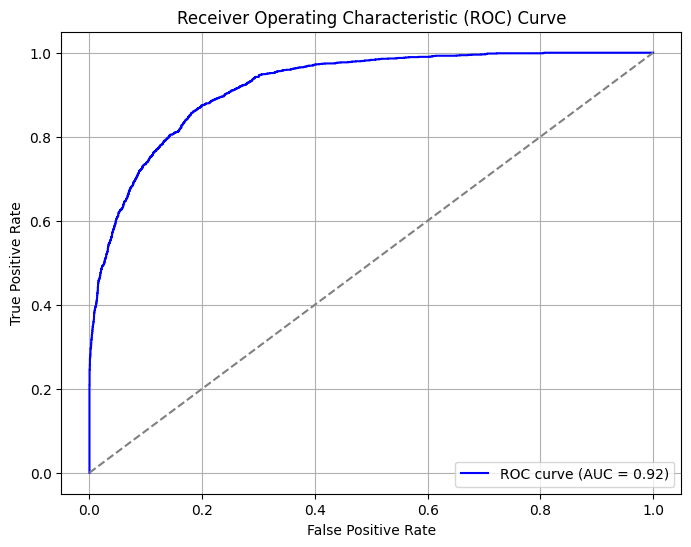

In [28]:
plot_roc_curve(fpr, tpr, roc_auc)

In [29]:
def plot_feature_importance(model, X, max_features=10):
    """
    Plots feature importance for the model, showing the top N features.

    Parameters:
    - model: trained model with a `feature_importances_` attribute (e.g., RandomForest, XGBoost)
    - X: DataFrame or array, features used for training the model (to extract feature names)
    - max_features: int, the number of top features to display (default is 10)
    """

    # Extract feature importances (if available)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

        # Get feature names from the DataFrame if it has columns, or generate default names if ndarray
        feature_names = (
            X.columns
            if isinstance(X, pd.DataFrame)
            else [f"Feature {i}" for i in range(X.shape[1])]
        )

        # Create DataFrame to sort and plot feature importance
        importance_df = (
            pd.DataFrame({"Feature": feature_names, "Importance": importances})
            .sort_values(by="Importance", ascending=False)
            .head(max_features)
        )

        # Plot top feature importances
        plt.figure(figsize=(8, 6))
        plt.barh(
            importance_df["Feature"],
            importance_df["Importance"],
            color="purple",
        )
        plt.xlabel("Importance")
        plt.title(f"Top {max_features} Feature Importances")
        plt.gca().invert_yaxis()  # Display most important feature at the top
        plt.show()
    else:
        print("No feature importance available for this model.")

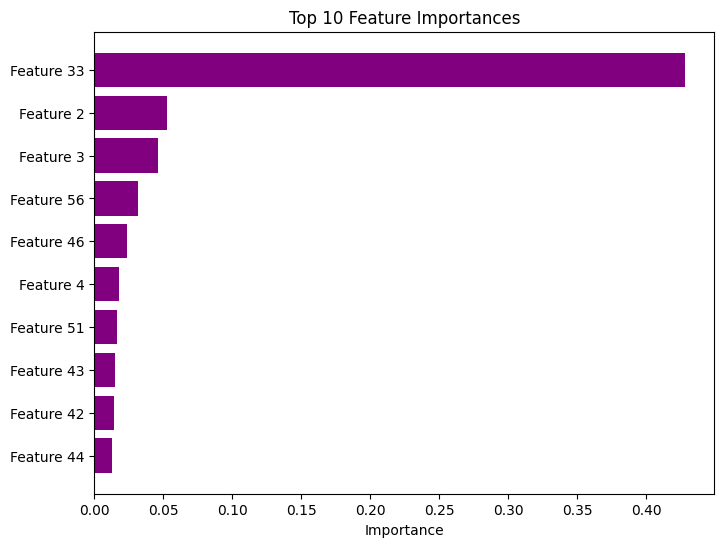

In [30]:
plot_feature_importance(best_model, X, max_features=10)